In [1]:
#importing the libraries

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import pandas as pd
import re
import numpy as np
from nltk.tokenize import  word_tokenize
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import math
from sklearn.pipeline import Pipeline

In [2]:
# pull and clean data

In [3]:
questions = pd.read_json("200k_questions.json")

In [4]:
questions

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680
...,...,...,...,...,...,...,...
216925,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,$2000,Turandot,Double Jeopardy!,4999
216926,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,$2000,a titmouse,Double Jeopardy!,4999
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",$2000,Clive Barker,Double Jeopardy!,4999
216928,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",$2000,Geronimo,Double Jeopardy!,4999


In [5]:
# clean columns
questions.columns = questions.columns.str.strip()

In [6]:
# Check and verify no missing/imcomplete data
questions[(questions.isna().any(axis=1)) & (questions['round'] != 'Final Jeopardy!') & (questions['round'] != 'Tiebreaker')]

,category,air_date,question,value,answer,round,show_number


In [7]:
questions.nunique()

category        27995
air_date         3640
question       216132
value             149
answer          88269
round               4
show_number      3640
dtype: int64

In [8]:
# Clean up Columns
questions['air_date'] = pd.to_datetime(questions['air_date'])

questions['value'] = questions['value'].str.replace("$","")
questions['value'] = questions['value'].str.replace(",","")
questions['value'] = questions['value'].fillna('0')
questions['value'] = questions['value'].astype(int)

/var/folders/dk/mw1t_ffs6jd0418t437scbb00000gn/T/ipykernel_88751/2207029533.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  questions['value'] = questions['value'].str.replace("$","")


In [9]:
questions = questions[questions['question'].str.contains('www')==False].reset_index(drop=True)
questions = questions[questions['category'].str.contains('missing')==False].reset_index(drop=True)
questions

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200,John Adams,Jeopardy!,4680
...,...,...,...,...,...,...,...
206362,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,2000,Turandot,Double Jeopardy!,4999
206363,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,2000,a titmouse,Double Jeopardy!,4999
206364,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",2000,Clive Barker,Double Jeopardy!,4999
206365,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",2000,Geronimo,Double Jeopardy!,4999


In [10]:
def make_difficulty_col(df):
    
    # Define conditions for difficulty levels
    conditions = [
        # Easy: Jeopardy! round and value <= $2000
        (df['round'] == 'Jeopardy!') & (df['value'] <= 2000),  

        # Average: Jeopardy! round and value > $2000 OR
        #          Double Jeopardy! round and value <= $3000
        ((df['round'] == 'Jeopardy!') & (df['value'] > 2000)) |
        ((df['round'] == 'Double Jeopardy!') & (df['value'] <= 3000)),  

        # Hard: Double Jeopardy! round and value > $4000 OR
        #       Final Jeopardy! OR Tiebreaker
        ((df['round'] == 'Double Jeopardy!') & (df['value'] > 3000)) | 
        (df['round'] == 'Final Jeopardy!') | (df['round'] == 'Tiebreaker')
    ]
    
    difficulties = ['easy', 'average', 'hard']
    
    # Apply conditions to create the 'question_difficulty' column
    df['Difficulty'] = np.select(conditions, difficulties, default='average')
    
    return df

In [11]:
df = make_difficulty_col(questions)
df

,category,air_date,question,value,answer,round,show_number,Difficulty
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",200,Copernicus,Jeopardy!,4680,easy
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,200,Jim Thorpe,Jeopardy!,4680,easy
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,200,Arizona,Jeopardy!,4680,easy
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",200,McDonald\'s,Jeopardy!,4680,easy
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",200,John Adams,Jeopardy!,4680,easy
...,...,...,...,...,...,...,...,...
206362,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,2000,Turandot,Double Jeopardy!,4999,average
206363,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,2000,a titmouse,Double Jeopardy!,4999,average
206364,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",2000,Clive Barker,Double Jeopardy!,4999,average
206365,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",2000,Geronimo,Double Jeopardy!,4999,average


In [12]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.sparse import hstack

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/kelly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kelly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kelly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text = "".join([char for char in text if char not in string.punctuation])
    text = " ".join([word for word in re.split('\W+', text) if word not in stop_words])
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [15]:
df['question'] = df['question'] .apply(clean_text)
df['category'] = df['category'].apply(clean_text)
df

,category,air_date,question,value,answer,round,show_number,Difficulty
0,history,2004-12-31,last 8 year life galileo house arrest espousin...,200,Copernicus,Jeopardy!,4680,easy
1,espns top 10 alltime athlete,2004-12-31,2 1912 olympian football star carlisle indian ...,200,Jim Thorpe,Jeopardy!,4680,easy
2,everybody talk,2004-12-31,city yuma state record average 4055 hour sunsh...,200,Arizona,Jeopardy!,4680,easy
3,company line,2004-12-31,1963 live art linkletter show company served b...,200,McDonald\'s,Jeopardy!,4680,easy
4,epitaph tribute,2004-12-31,signer dec indep framer constitution mass seco...,200,John Adams,Jeopardy!,4680,easy
...,...,...,...,...,...,...,...,...
206362,riddle,2006-05-11,puccini opera turn solution 3 riddle posed her...,2000,Turandot,Double Jeopardy!,4999,average
206363,bird,2006-05-11,north america term properly applied 4 specie c...,2000,a titmouse,Double Jeopardy!,4999,average
206364,author youth,2006-05-11,penny lane hellraiser grew barber shave anothe...,2000,Clive Barker,Double Jeopardy!,4999,average
206365,quotation,2006-05-11,ft sill okla made plea arizona land home fathe...,2000,Geronimo,Double Jeopardy!,4999,average


In [16]:
# Feature extraction with TF-IDF
tfidf_vectorizer_q = TfidfVectorizer(max_features=1000)
text_tfidf = tfidf_vectorizer_q.fit_transform(df['question'])

tfidf_vectorizer_c = TfidfVectorizer(max_features=1000)
category_tfidf = tfidf_vectorizer_c.fit_transform(df['category'])
text_tfidf.shape

(206367, 1000)

In [17]:
# Define a mapping that reflects the natural ordering of difficulty
difficulty_mapping = {'easy': 0, 'average': 1, 'hard': 2}

# Apply the mapping to the 'Difficulty' column
df['Difficulty_Encoded'] = df['Difficulty'].map(difficulty_mapping)

print(df[['Difficulty', 'Difficulty_Encoded']])

       Difficulty  Difficulty_Encoded
0            easy                   0
1            easy                   0
2            easy                   0
3            easy                   0
4            easy                   0
...           ...                 ...
206362    average                   1
206363    average                   1
206364    average                   1
206365    average                   1
206366       hard                   2

[206367 rows x 2 columns]


In [18]:
text_tfidf_dense = text_tfidf.toarray()
category_tfidf_dense = category_tfidf.toarray()

# Combine all features into a single feature matrix
from scipy.sparse import hstack
features = np.hstack((text_tfidf_dense, category_tfidf_dense, df['Difficulty_Encoded'].values.reshape(-1, 1)))

features.shape

(206367, 2001)

In [19]:
#Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  

# Fit PCA on the scaled feature matrix and transform the data
features_pca = pca.fit_transform(features_scaled)

print("Original feature space:", features_scaled.shape[1])
print("Reduced feature space:", features_pca.shape[1])

Original feature space: 2001
Reduced feature space: 1825


/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

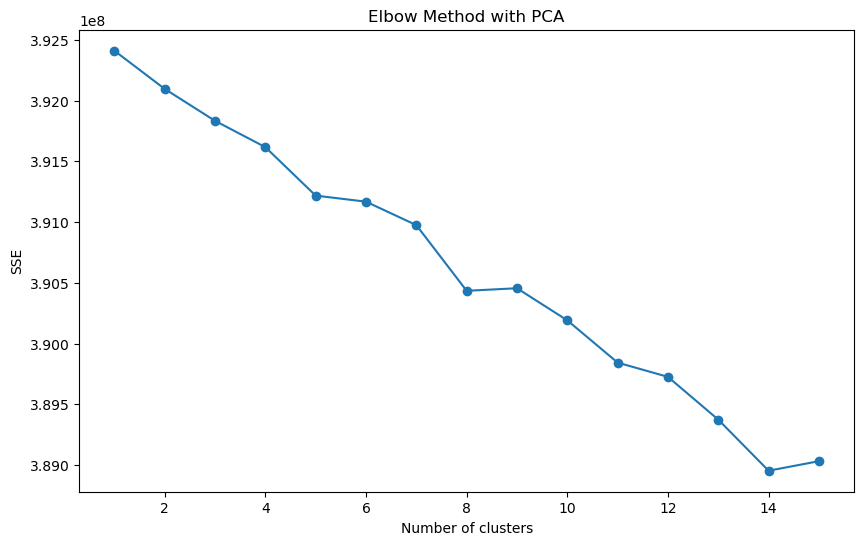

In [21]:
# Apply the elbow method on the reduced dataset from PCA
sse = []
for k in range(1, 16):  # Test k from 1 to 15
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    sse.append(kmeans.inertia_)

# Plot SSE for each k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), sse, marker='o')
plt.title('Elbow Method with PCA')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [24]:
#K-Means clustering 
num_clusters = 14
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features_pca)

/Users/kelly/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [25]:
# Assign clusters back to the original DataFrame for analysis
df['Cluster'] = clusters

# Output the first few rows of the DataFrame to inspect
print(df.head())

                       category   air_date  \
0                       history 2004-12-31   
1  espns top 10 alltime athlete 2004-12-31   
2                everybody talk 2004-12-31   
3                  company line 2004-12-31   
4               epitaph tribute 2004-12-31   

                                            question  value       answer  \
0  last 8 year life galileo house arrest espousin...    200   Copernicus   
1  2 1912 olympian football star carlisle indian ...    200   Jim Thorpe   
2  city yuma state record average 4055 hour sunsh...    200      Arizona   
3  1963 live art linkletter show company served b...    200  McDonald\'s   
4  signer dec indep framer constitution mass seco...    200   John Adams   

       round  show_number Difficulty  Difficulty_Encoded  Cluster  
0  Jeopardy!         4680       easy                   0        1  
1  Jeopardy!         4680       easy                   0       10  
2  Jeopardy!         4680       easy                   0      

/var/folders/dk/mw1t_ffs6jd0418t437scbb00000gn/T/ipykernel_88751/3369909687.py:15: UserWarning: 
The palette list has fewer values (10) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette=sns.color_palette("hsv", 10), data=df_tsne)


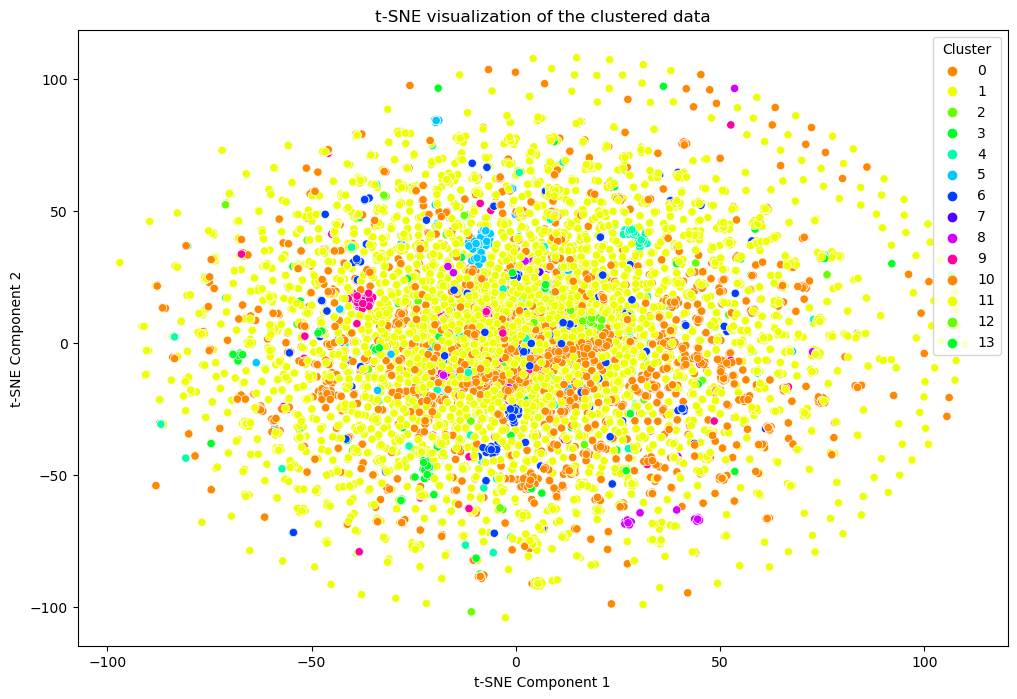

In [26]:
# t-SNE for dimensionality reduction to visualize the data
# Using a sample of the data to speed up the t-SNE process
sample_indices = np.random.choice(features_pca.shape[0], size=10000, replace=False)
features_sample = features_pca[sample_indices]

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
features_tsne = tsne.fit_transform(features_sample)

# Create a DataFrame for the sample data with t-SNE components and cluster assignments
df_tsne = pd.DataFrame(features_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = df['Cluster'].iloc[sample_indices].values

# Plot the clusters as per t-SNE components
plt.figure(figsize=(12, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette=sns.color_palette("hsv", 10), data=df_tsne)
plt.title('t-SNE visualization of the clustered data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

In [28]:
top_n = 5  # Number of top terms to extract

# Get feature names for questions and categories
question_feature_names = tfidf_vectorizer_q.get_feature_names_out()
category_feature_names = tfidf_vectorizer_c.get_feature_names_out()

for i in range(num_clusters):
    print(f"\nCluster {i}:")

    # Find indices of questions in the cluster
    cluster_indices = df[df['Cluster'] == i].index

    # Aggregate TF-IDF scores for these questions and categories
    question_tfidf_sum = np.array(np.sum(text_tfidf[cluster_indices], axis=0)).flatten()
    category_tfidf_sum = np.array(np.sum(category_tfidf[cluster_indices], axis=0)).flatten()

    # Get top terms in 'Question' and 'Category' for the cluster
    top_question_terms_indices = question_tfidf_sum.argsort()[-top_n:][::-1]
    top_category_terms_indices = category_tfidf_sum.argsort()[-top_n:][::-1]

    top_question_terms = [question_feature_names[idx] for idx in top_question_terms_indices]
    top_category_terms = [category_feature_names[idx] for idx in top_category_terms_indices]

    # Output the top question terms and category terms for the cluster
    print("Top Question Terms:", top_question_terms)
    print("Top Category Terms:", top_category_terms)

    # Get and output the most common categories in the cluster
    common_categories = df.loc[cluster_indices, 'category'].value_counts().head(top_n)
    print(f"Common categories:\n{common_categories}\n")



Cluster 0:
Top Question Terms: ['film', 'title', 'novel', 'played', 'wrote']
Top Category Terms: ['movie', 'tv', 'film', 'literature', 'book']
Common categories:
literature     461
movie          411
               403
opera          281
shakespeare    275
Name: category, dtype: int64


Cluster 1:
Top Question Terms: ['one', 'name', 'city', 'first', 'state']
Top Category Terms: ['history', 'world', 'name', 'state', 'science']
Common categories:
                    1331
science              540
american history     376
world history        356
history              353
Name: category, dtype: int64


Cluster 2:
Top Question Terms: ['post', '1959', 'held', 'first', 'office']
Top Category Terms: ['history', 'cabinet', 'woman', 'century', 'american']
Common categories:
u history                 12
cabinet                    9
new york post headline     7
etiquette                  5
world leader               4
Name: category, dtype: int64


Cluster 3:
Top Question Terms: ['ballet', 'music'

In [29]:
# Analyzing Cluster Sizes and Difficulty
cluster_sizes = df['Cluster'].value_counts()
print(cluster_sizes)

# Calculate the proportion of difficulty levels within each cluster
for i in range(num_clusters):
    print(f"\nCluster {i} Difficulty Distribution:")
    # Select the subset of the DataFrame that corresponds to the current cluster
    cluster_subset = df[df['Cluster'] == i]
    
    # Use value_counts to get the count of each difficulty level, normalize=True gives the proportion
    difficulty_counts = cluster_subset['Difficulty'].value_counts(normalize=True)
    
    # Print the difficulty distribution
    print(difficulty_counts)


1     138465
0      45863
6       5102
11      3264
4       2159
9       2087
13      2084
10      2037
5       1685
12      1160
8        923
2        749
3        588
7        201
Name: Cluster, dtype: int64

Cluster 0 Difficulty Distribution:
average    0.549441
easy       0.425201
hard       0.025358
Name: Difficulty, dtype: float64

Cluster 1 Difficulty Distribution:
easy       0.520001
average    0.458036
hard       0.021962
Name: Difficulty, dtype: float64

Cluster 2 Difficulty Distribution:
average    0.500668
easy       0.457944
hard       0.041389
Name: Difficulty, dtype: float64

Cluster 3 Difficulty Distribution:
average    0.744898
easy       0.231293
hard       0.023810
Name: Difficulty, dtype: float64

Cluster 4 Difficulty Distribution:
easy       0.513201
average    0.460398
hard       0.026401
Name: Difficulty, dtype: float64

Cluster 5 Difficulty Distribution:
average    0.553116
easy       0.420178
hard       0.026706
Name: Difficulty, dtype: float64

Cluster 6 Diffi